In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import healpy as hp
from healpy.visufunc import projplot
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord, angular_separation, Angle
import astropy.units as u
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools
from Secrest_dipole import SecrestDipole
import dipole
from jackknife import dipole_uncertainty_jk

In [3]:
plt.rcParams.update({
    'text.usetex' : False,
    'font.family' : 'serif'
})

### CMB dipole

In [4]:
cmb_amp, cmb_dir = dipole.cmb_dipole(frame='galactic')

## CatWISE

In [5]:
# Catwise AGNs
catwise_kwargs = dict(initial_catfn='catwise_agns_master.fits',
                      catname='catwise_agns', mag='w1', load_init=False)

# galactic plane
blims = np.arange(15, 71, 5)
dipoles_bcut = []
for i, blim in enumerate(blims):
    d = SecrestDipole(blim=blim, maglim=16.4, **catwise_kwargs)
    map_ = d.load_hpxelatcorr()
    dipoles_bcut.append(d.compute_dipole(map_))

# magnitude limits
maglims = np.arange(15.7, 16.81, 0.1)
dipoles_maglims = []
for i, maglim in enumerate(maglims):
    d = SecrestDipole(maglim=maglim, **catwise_kwargs)
    map_ = d.load_hpxelatcorr()
    dipoles_maglims.append(d.compute_dipole(map_))

# mask radii
factors = np.array([0., 0.2, 0.5, 1., 1.5, 2., 2.5])
dipoles_masks = []
for i, factor in enumerate(factors):
    save_tag = f'_r{factor:.1f}'
    d = SecrestDipole(save_tag=save_tag, maglim=16.4, **catwise_kwargs)
    map_ = d.load_hpxelatcorr()
    dipoles_masks.append(d.compute_dipole(map_))
    
# format for plotting
dips_b = np.array([
    [x[0], x[1].l.deg, x[1].b.deg] for x in dipoles_bcut
])
dips_maglims = np.array([
    [x[0], x[1].l.deg, x[1].b.deg] for x in dipoles_maglims
])
dips_masks = np.array([
    [x[0], x[1].l.deg, x[1].b.deg] for x in dipoles_masks
])

In [6]:
# load jackknife uncertainties
# old
res = np.load('/scratch/aew492/quasars/catalogs/catwise_agns/choices/old_jackknife_uncertainties_amps/jackknife_uncertainties_blims.npy')
assert np.all(res[0] == blims)
old_stds_blims = res[1]
res = np.load('/scratch/aew492/quasars/catalogs/catwise_agns/choices/old_jackknife_uncertainties_amps/jackknife_uncertainties_maglims.npy')
assert np.all(res[0][::-1] == maglims)
old_stds_maglims = res[1][::-1]
res = np.load('/scratch/aew492/quasars/catalogs/catwise_agns/choices/old_jackknife_uncertainties_amps/jackknife_uncertainties_masks.npy')
assert np.all(res[0] == factors)
old_stds_masks = res[1]
# new
res = np.load('/scratch/aew492/quasars/catalogs/catwise_agns/choices/jackknife_uncertainties_blims.npy')
assert np.all(res[:,0] == blims)
stds_blims, stds_blims_dir = res[:,1:].T
res = np.load('/scratch/aew492/quasars/catalogs/catwise_agns/choices/jackknife_uncertainties_maglims.npy')
assert np.all(res[:,0][::-1] == maglims)
stds_maglims, stds_maglims_dir = res[:,1:][::-1].T
res = np.load('/scratch/aew492/quasars/catalogs/catwise_agns/choices/jackknife_uncertainties_masks.npy')
assert np.all(res[:,0] == factors)
stds_masks, stds_maglims_dir = res[:,1:].T

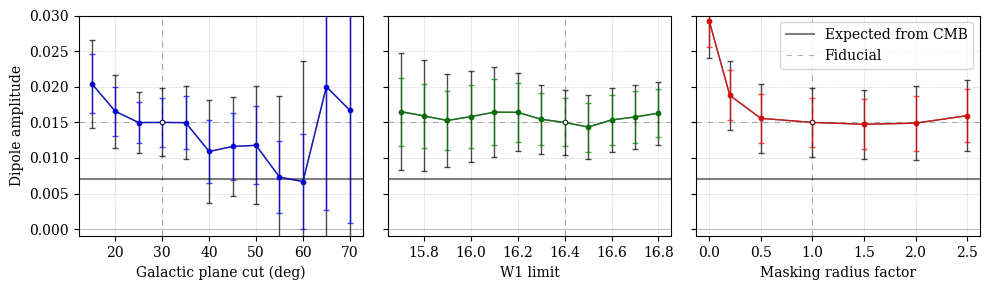

In [7]:
# amplitudes
fig, axs = plt.subplots(1, 3, figsize=(10,3))

kwargs = dict(lw=1, alpha=0.7, marker='.', capsize=2)
fid_kwargs = dict(marker='.', c='w', mec='k', mew=0.5, zorder=10)

# fiducial
S21_fid = dips_b[blims==30.].flatten()

# galactic plane
axs[0].errorbar(blims, dips_b[:,0], yerr=old_stds_blims, c='k', **kwargs)
axs[0].errorbar(blims, dips_b[:,0], yerr=stds_blims, c='b', **kwargs)
axs[0].set_xlabel('Galactic plane cut (deg)')
axs[0].axvline(30, alpha=0.3, c='k', ls=(0,(5,5)), lw=0.8)
axs[0].plot(30, dips_b[:,0][blims==30], **fid_kwargs)
axs[0].set_xticks(np.arange(20, 71, 10))
# magnitude limit
axs[1].errorbar(maglims, dips_maglims[:,0], yerr=old_stds_maglims, c='k', **kwargs)
axs[1].errorbar(maglims, dips_maglims[:,0], yerr=stds_maglims, c='g', **kwargs)
axs[1].set_xlabel('W1 limit')
axs[1].axvline(16.4, alpha=0.3, c='k', ls=(0,(5,5)), lw=0.8)
axs[1].plot(16.4, dips_maglims[:,0][maglims==16.4], **fid_kwargs)
axs[1].set_xticks(np.arange(15.8, 16.81, 0.2))
# mask radii
axs[2].errorbar(factors, dips_masks[:,0], yerr=old_stds_masks, c='k', **kwargs)
axs[2].errorbar(factors, dips_masks[:,0], yerr=stds_masks, c='r', **kwargs)
axs[2].set_xlabel('Masking radius factor')
axs[2].axvline(1., alpha=0.3, c='k', ls=(0,(5,5)), lw=0.8)
axs[2].plot(1., dips_masks[:,0][factors==1.], **fid_kwargs)

# CMB and other formatting
for ax in axs:
    ax.grid(lw=0.5, alpha=0.5, ls='--')
    ax.axhline(0.007, c='k', label='Expected from CMB', alpha=0.5, lw=1.5)
    ax.set_ylim(-.001, 0.03)
    ax.axhline(0, alpha=0.3, color='k', lw=0.5)
    ax.axhline(S21_fid[0], alpha=0.3, c='k', ls=(0,(5,5)), lw=0.8, label='Fiducial')
for ax in axs[1:]:
    ax.set_yticklabels([])
axs[0].set_ylabel('Dipole amplitude')
axs[-1].legend()
fig.tight_layout()

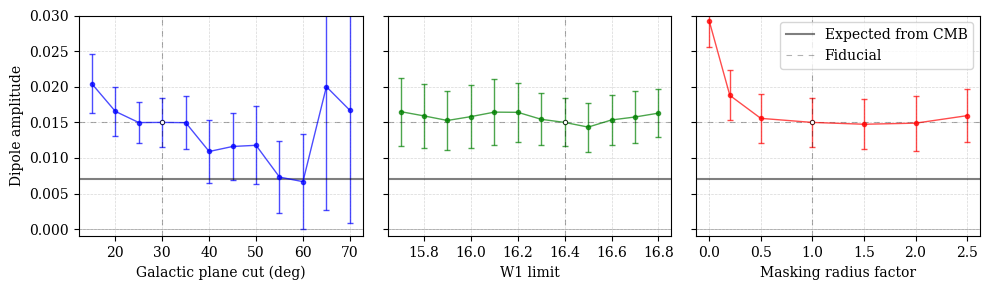

In [8]:
# amplitudes
fig, axs = plt.subplots(1, 3, figsize=(10,3))

kwargs = dict(lw=1, alpha=0.7, marker='.', capsize=2)
fid_kwargs = dict(marker='.', c='w', mec='k', mew=0.5, zorder=10)

# fiducial
S21_fid = dips_b[blims==30.].flatten()

# galactic plane
axs[0].errorbar(blims, dips_b[:,0], yerr=stds_blims, c='b', **kwargs)
axs[0].set_xlabel('Galactic plane cut (deg)')
axs[0].axvline(30, alpha=0.3, c='k', ls=(0,(5,5)), lw=0.8)
axs[0].plot(30, dips_b[:,0][blims==30], **fid_kwargs)
axs[0].set_xticks(np.arange(20, 71, 10))
# magnitude limit
axs[1].errorbar(maglims, dips_maglims[:,0], yerr=stds_maglims, c='g', **kwargs)
axs[1].set_xlabel('W1 limit')
axs[1].axvline(16.4, alpha=0.3, c='k', ls=(0,(5,5)), lw=0.8)
axs[1].plot(16.4, dips_maglims[:,0][maglims==16.4], **fid_kwargs)
axs[1].set_xticks(np.arange(15.8, 16.81, 0.2))
# mask radii
axs[2].errorbar(factors, dips_masks[:,0], yerr=stds_masks, c='r', **kwargs)
axs[2].set_xlabel('Masking radius factor')
axs[2].axvline(1., alpha=0.3, c='k', ls=(0,(5,5)), lw=0.8)
axs[2].plot(1., dips_masks[:,0][factors==1.], **fid_kwargs)

# CMB and other formatting
for ax in axs:
    ax.grid(lw=0.5, alpha=0.5, ls='--')
    ax.axhline(0.007, c='k', label='Expected from CMB', alpha=0.5, lw=1.5)
    ax.set_ylim(-.001, 0.03)
    ax.axhline(0, alpha=0.3, color='k', lw=0.5)
    ax.axhline(S21_fid[0], alpha=0.3, c='k', ls=(0,(5,5)), lw=0.8, label='Fiducial')
for ax in axs[1:]:
    ax.set_yticklabels([])
axs[0].set_ylabel('Dipole amplitude')
axs[-1].legend()
fig.tight_layout()

### Quaia

In [9]:
quaia_kwargs = dict(initial_catfn='quaia_G20.5.fits',
                      catname='quaia', mag='G', load_init=False, compcorrect=True)

# galactic plane
blims = np.arange(15, 71, 5)
dipoles_bcut = []
for i, blim in enumerate(blims):
    d = SecrestDipole(blim=blim, maglim=20., save_tag='_r1.0', **quaia_kwargs)
    map_ = d.load_hpxelatcorr()
    dipoles_bcut.append(d.compute_dipole(map_))

# magnitude limit
maglims = np.arange(19., 20.51, 0.1)
dipoles_maglims = []
for i, maglim in enumerate(maglims):
    d = SecrestDipole(maglim=maglim, blim=30, save_tag='_r1.0', **quaia_kwargs)
    map_ = d.load_hpxelatcorr()
    dipoles_maglims.append(d.compute_dipole(map_))

# masking radii
factors = np.array([0., 0.2, 0.5, 1., 1.5, 2., 2.5])
dipoles_masks = []
for i, factor in enumerate(factors):
    save_tag = f'_r{factor:.1f}'
    d = SecrestDipole(save_tag=save_tag, maglim=20., blim=30, **quaia_kwargs)
    map_ = d.load_hpxelatcorr()
    dipoles_masks.append(d.compute_dipole(map_))

# format for plotting
dips_b = np.array([
    [x[0], x[1].l.deg, x[1].b.deg] for x in dipoles_bcut
])
dips_maglims = np.array([
    [x[0], x[1].l.deg, x[1].b.deg] for x in dipoles_maglims
])
dips_masks = np.array([
    [x[0], x[1].l.deg, x[1].b.deg] for x in dipoles_masks
])

In [10]:
# load jackknife uncertainties
# res = np.load('/scratch/aew492/quasars/catalogs/quaia/choices/old_jackknife_uncertainties_amps/jackknife_uncertainties_blims.npy')
# this one got overwritten by the new jackknife...
# assert np.all(res[0] == blims)
res = np.load('/scratch/aew492/quasars/catalogs/quaia/choices/old_jackknife_uncertainties_amps/jackknife_uncertainties_maglims.npy')
assert np.all(res[0][::-1] == maglims)
old_stds_maglims = res[1][::-1]
res = np.load('/scratch/aew492/quasars/catalogs/quaia/choices/old_jackknife_uncertainties_amps/jackknife_uncertainties_masks.npy')
assert np.all(res[0] == factors)
old_stds_masks = res[1]
# new
res = np.load('/scratch/aew492/quasars/catalogs/quaia/choices/jackknife_uncertainties_blims.npy')
assert np.all(res[:,0] == blims)
stds_blims, stds_blims_dir = res[:,1:].T
res = np.load('/scratch/aew492/quasars/catalogs/quaia/choices/jackknife_uncertainties_maglims.npy')
assert np.all(res[:,0][::-1] == maglims)
stds_maglims, stds_maglims_dir = res[:,1:][::-1].T
res = np.load('/scratch/aew492/quasars/catalogs/quaia/choices/jackknife_uncertainties_masks.npy')
assert np.all(res[:,0] == factors)
stds_masks, stds_maglims_dir = res[:,1:].T

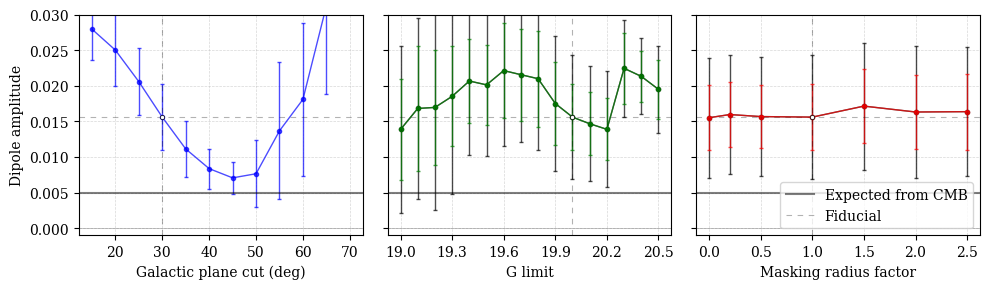

In [11]:
# amplitudes
fig, axs = plt.subplots(1, 3, figsize=(10,3))

kwargs = dict(lw=1, alpha=0.7, marker='.', capsize=1.5)
fid_kwargs = dict(marker='.', c='w', mec='k', mew=0.5, zorder=10)

# fiducial
quaia_fid = dips_b[blims==30.][0]

# galactic plane
axs[0].errorbar(blims, dips_b[:,0], yerr=stds_blims, c='b', **kwargs)
axs[0].set_xlabel('Galactic plane cut (deg)')
axs[0].axvline(30., alpha=0.3, c='k', ls=(0,(5,5)), lw=0.8)
axs[0].plot(30., dips_b[:,0][blims==30.], **fid_kwargs)
axs[0].set_xticks(np.arange(20, 71, 10))
# magnitude limit
axs[1].errorbar(maglims, dips_maglims[:,0], yerr=old_stds_maglims, c='k', **kwargs)
axs[1].errorbar(maglims, dips_maglims[:,0], yerr=stds_maglims, c='g', **kwargs)
axs[1].set_xlabel('G limit')
axs[1].axvline(20., alpha=0.3, c='k', ls=(0,(5,5)), lw=0.8)
axs[1].plot(20., dips_b[:,0][blims==30.], **fid_kwargs)
axs[1].set_xticks(np.arange(19., 20.51, 0.3))
# mask radii
axs[2].errorbar(factors, dips_masks[:,0], yerr=old_stds_masks, c='k', **kwargs)
axs[2].errorbar(factors, dips_masks[:,0], yerr=stds_masks, c='r', **kwargs)
axs[2].set_xlabel('Masking radius factor')
axs[2].axvline(1., alpha=0.3, c='k', ls=(0,(5,5)), lw=0.8)
axs[2].plot(1., dips_masks[:,0][factors==1.], **fid_kwargs)

# CMB and other formatting
for ax in axs:
    ax.set_yticks(np.arange(0, 0.0351, 0.005))
    ax.grid(lw=0.5, alpha=0.5, ls='--')
    ax.axhline(0.005, c='k', label='Expected from CMB', alpha=0.5, lw=1.5)
    ax.set_ylim(-.001, 0.03)
    ax.axhline(0, alpha=0.3, color='k', lw=0.5)
    ax.axhline(quaia_fid[0], alpha=0.3, c='k', ls=(0,(5,5)), lw=0.8, label='Fiducial')
for ax in axs[1:]:
    ax.set_yticklabels([])
axs[0].set_ylabel('Dipole amplitude')
axs[-1].legend(loc=4)
fig.tight_layout()

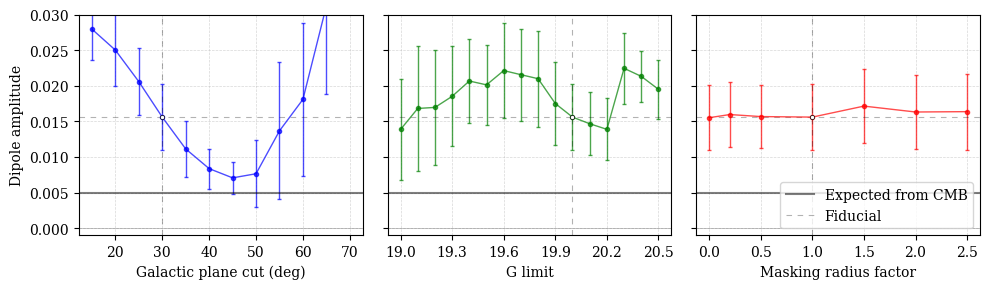

In [12]:
# amplitudes
fig, axs = plt.subplots(1, 3, figsize=(10,3))

kwargs = dict(lw=1, alpha=0.7, marker='.', capsize=1.5)
fid_kwargs = dict(marker='.', c='w', mec='k', mew=0.5, zorder=10)

# fiducial
quaia_fid = dips_b[blims==30.][0]

# galactic plane
axs[0].errorbar(blims, dips_b[:,0], yerr=stds_blims, c='b', **kwargs)
axs[0].set_xlabel('Galactic plane cut (deg)')
axs[0].axvline(30., alpha=0.3, c='k', ls=(0,(5,5)), lw=0.8)
axs[0].plot(30., dips_b[:,0][blims==30.], **fid_kwargs)
axs[0].set_xticks(np.arange(20, 71, 10))
# magnitude limit
axs[1].errorbar(maglims, dips_maglims[:,0], yerr=stds_maglims, c='g', **kwargs)
axs[1].set_xlabel('G limit')
axs[1].axvline(20., alpha=0.3, c='k', ls=(0,(5,5)), lw=0.8)
axs[1].plot(20., dips_b[:,0][blims==30.], **fid_kwargs)
axs[1].set_xticks(np.arange(19., 20.51, 0.3))
# mask radii
axs[2].errorbar(factors, dips_masks[:,0], yerr=stds_masks, c='r', **kwargs)
axs[2].set_xlabel('Masking radius factor')
axs[2].axvline(1., alpha=0.3, c='k', ls=(0,(5,5)), lw=0.8)
axs[2].plot(1., dips_masks[:,0][factors==1.], **fid_kwargs)

# CMB and other formatting
for ax in axs:
    ax.set_yticks(np.arange(0, 0.0351, 0.005))
    ax.grid(lw=0.5, alpha=0.5, ls='--')
    ax.axhline(0.005, c='k', label='Expected from CMB', alpha=0.5, lw=1.5)
    ax.set_ylim(-.001, 0.03)
    ax.axhline(0, alpha=0.3, color='k', lw=0.5)
    ax.axhline(quaia_fid[0], alpha=0.3, c='k', ls=(0,(5,5)), lw=0.8, label='Fiducial')
for ax in axs[1:]:
    ax.set_yticklabels([])
axs[0].set_ylabel('Dipole amplitude')
axs[-1].legend(loc=4)
fig.tight_layout()

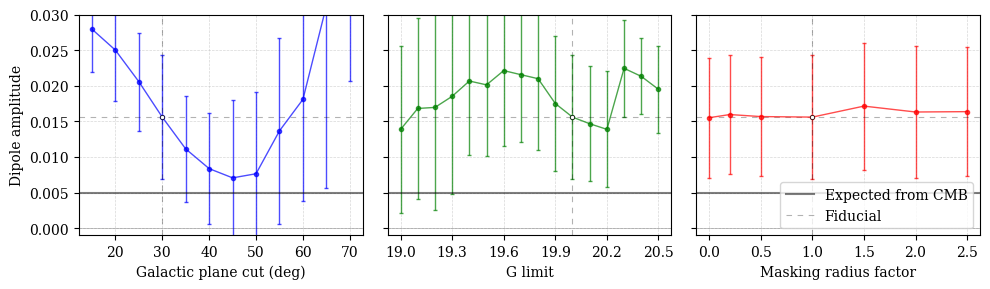

In [13]:
# amplitudes
fig, axs = plt.subplots(1, 3, figsize=(10,3))

kwargs = dict(lw=1, alpha=0.7, marker='.', capsize=1.5)
fid_kwargs = dict(marker='.', c='w', mec='k', mew=0.5, zorder=10)

# fiducial
quaia_fid = dips_b[blims==30.][0]

# galactic plane
axs[0].errorbar(blims, dips_b[:,0], yerr=stds_blims, c='b', **kwargs)
axs[0].set_xlabel('Galactic plane cut (deg)')
axs[0].axvline(30., alpha=0.3, c='k', ls=(0,(5,5)), lw=0.8)
axs[0].plot(30., dips_b[:,0][blims==30.], **fid_kwargs)
axs[0].set_xticks(np.arange(20, 71, 10))
# magnitude limit
axs[1].errorbar(maglims, dips_maglims[:,0], yerr=stds_maglims, c='g', **kwargs)
axs[1].set_xlabel('G limit')
axs[1].axvline(20., alpha=0.3, c='k', ls=(0,(5,5)), lw=0.8)
axs[1].plot(20., dips_b[:,0][blims==30.], **fid_kwargs)
axs[1].set_xticks(np.arange(19., 20.51, 0.3))
# mask radii
axs[2].errorbar(factors, dips_masks[:,0], yerr=stds_masks, c='r', **kwargs)
axs[2].set_xlabel('Masking radius factor')
axs[2].axvline(1., alpha=0.3, c='k', ls=(0,(5,5)), lw=0.8)
axs[2].plot(1., dips_masks[:,0][factors==1.], **fid_kwargs)

# CMB and other formatting
for ax in axs:
    ax.set_yticks(np.arange(0, 0.0351, 0.005))
    ax.grid(lw=0.5, alpha=0.5, ls='--')
    ax.axhline(0.005, c='k', label='Expected from CMB', alpha=0.5, lw=1.5)
    ax.set_ylim(-.001, 0.03)
    ax.axhline(0, alpha=0.3, color='k', lw=0.5)
    ax.axhline(quaia_fid[0], alpha=0.3, c='k', ls=(0,(5,5)), lw=0.8, label='Fiducial')
for ax in axs[1:]:
    ax.set_yticklabels([])
axs[0].set_ylabel('Dipole amplitude')
axs[-1].legend(loc=4)
fig.tight_layout()

### direction